# Loading and pre-processing

This widget is the first step in the workflow. It allows to:
- load a dataset
- correct the image background and export the data in an efficient data format (zarr)
- select a main Region of Interest (ROI), i.e. the global image area to be analyzed
- select analysis ROIs, i.e. smaller regions used to compute end-members
- create masks for image regions to be discarded

These categories of operations are separated into tabs as visible below.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import napari
import numpy as np
from napari.utils import nbscreenshot
from napari_sediment.widgets.sediment_widget import SedimentWidget

In [3]:
viewer = napari.Viewer()
self = SedimentWidget(viewer)
viewer.window.add_dock_widget(self);

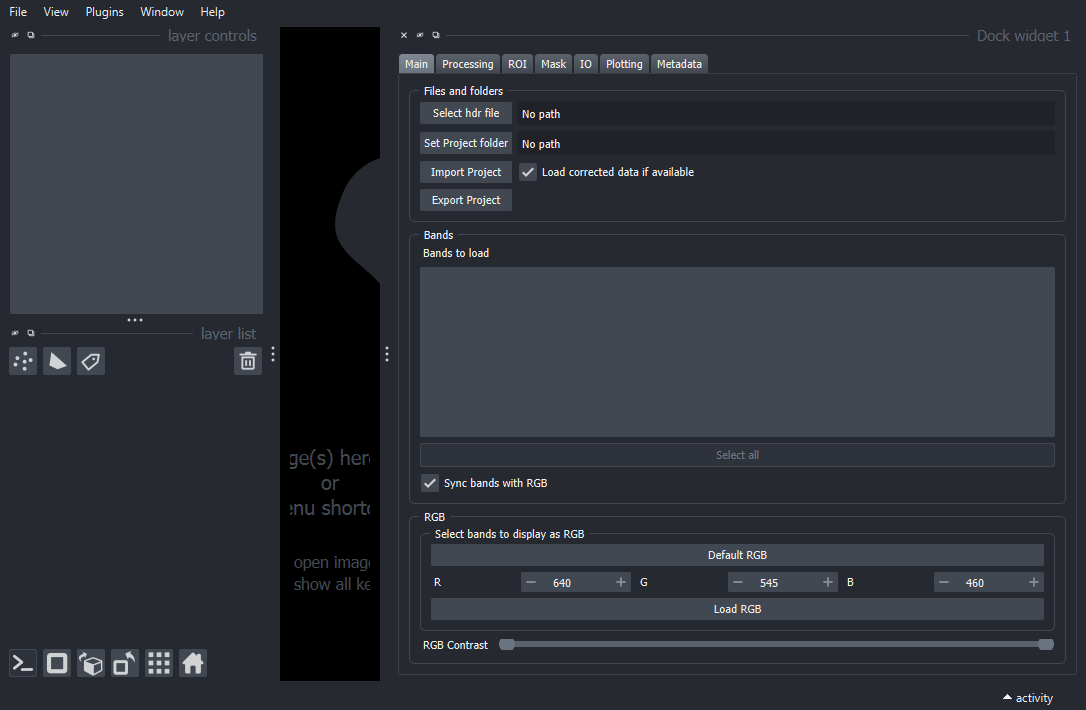

In [4]:
nbscreenshot(viewer)

## Main

### Files and folders

Here you can select the dataset to analyze by choosing the corresponding *hdr file* (and not the raw file). When a file is selected, the corresponding White and Dark correction images are searched for automatically. For this to work the corresponding the following folder structure is expected:
```
Data_folder
├──Experiment1_123
│   └── capture
│       ├── myfile_123.hdr
│       ├── myfile_123.raw
│       ├── DARKREF_myfile_123.hdr
│       ├── DARKREF_myfile_123.raw
│       └── ...
└──Experiment1_WR_123
    └── capture
        ├── WHITEREF_123.hdr
        ├── WHITEREF_123.raw
        ├── DARKREF_myfile_123.hdr
        ├── DARKREF_myfile_123.raw
        └── ...

```

The main files are ```myfile_123.hdr``` and ```myfile_123.raw``` while the other files are used as references to normalize the image. We use ```Select hdr file``` to point to an ```hdr``` file and load it. We can also specify a location for data export with ```Select Project folder```. This is the location where normalized data, indices etc. will be saved. Upon selecting a dataset, data are automatically loaded.

Here we used a synthetic dataset allowing to present the features of the software in a simplified way.

In [5]:
import os
synth_path = Path(os.path.expanduser("~")).joinpath('Sediment_synthetic')

In [6]:
# if you run this notebook, you need to create the dataset first by executing this cell. Data are saved in your home folder. Exported data are in the same location
from napari_sediment.data.synthetic import generate_synthetic_dataset, save_test_dataset
save_test_dataset(data_name='Demo', save_path=synth_path.joinpath('sediment_data'),
                  image_mean=1000, image_std=5, min_val=300, max_val=400, height=130, width=120,
                  ref_height=20, channels=80, white_ref_added_signal=2000, pattern_weight=10,
                  pattern_width=10, random_seed=2)
save_test_dataset(data_name='Demo2', save_path=synth_path.joinpath('sediment_data'),
                  image_mean=1000, image_std=5, min_val=300, max_val=400, height=130, width=120,
                  ref_height=20, channels=80, white_ref_added_signal=2000, pattern_weight=10,
                  pattern_width=10, random_seed=1)

export_path = synth_path.joinpath('sediment_export')
if not os.path.isdir(export_path):
    os.makedirs(export_path, exist_ok=True)
export_path = synth_path.joinpath('sediment_export_series')
if not os.path.isdir(export_path):
    os.makedirs(export_path, exist_ok=True)

In [7]:
imhdr_path = synth_path.joinpath('sediment_data/Demo/capture/Demo.hdr')
self.set_paths(imhdr_path)
self._on_select_file()
self.export_folder = synth_path.joinpath('sediment_export')
self.export_path_display.setText(self.export_folder.as_posix())

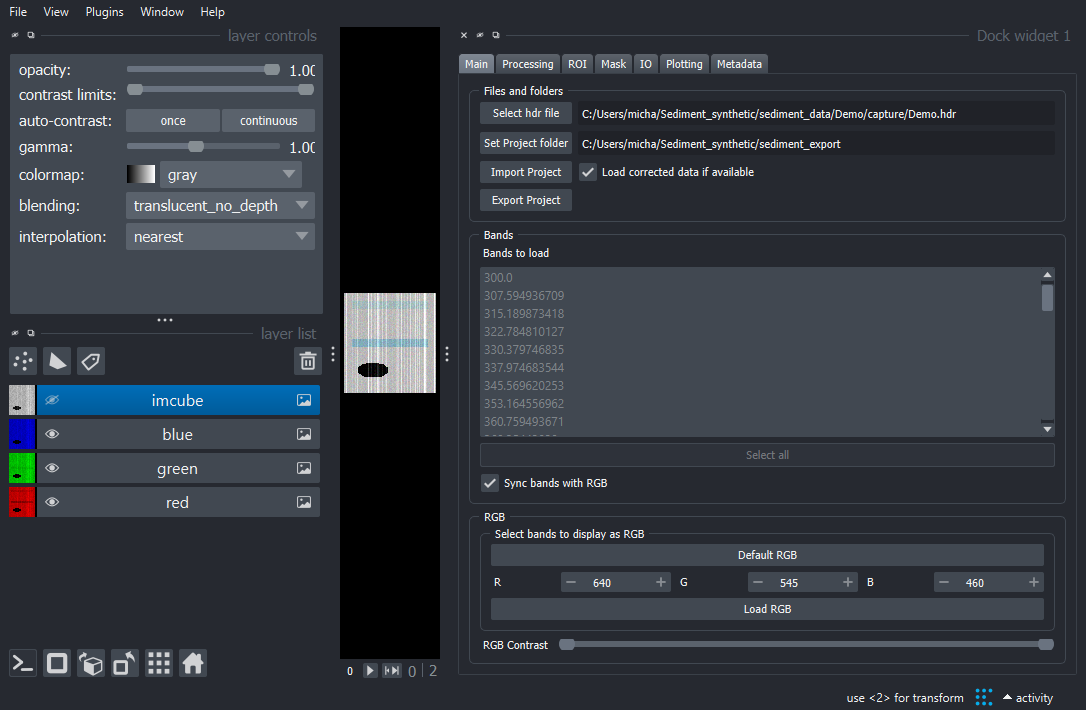

In [8]:
nbscreenshot(viewer)

If you want to reload previously analyzed data, you can use the ```Import Project``` button and point to the export folder. If you want to export the current project (masks, ROIs etc.) you can use the ```Export Project``` button.

### Bands

Once a dataset has been loaded, all available bands are displayed in ```Bands to load```. One can then manually click on bands to be loaded. Bands are represented in two formats in the layer list and the viewer:
- ```imcube```: this layer contains all the selected bands loaded as a stack, i.e. they can be browsed through using the slider at the bottom of the viewer. This is the data that is generally used for computations
- ```red```, ```green```, ```blue```: three bands can also be visualized in separate layers. This allows to visualize these bands in a single RGB image.

In principle these two representations are independent, i.e. one can select bands for ```imcube``` and other bands for RGB. However it is often advantageous to keep the two representation in sync in order to visualize in RGB processing made on ```imcube```. This can be achieved by checking the ```Sync bands with RGB``` option.

To select multiple bands, hold the Shift key. The imported bands are stored in the ```imcube``` layer and not in separate layers . Beware that for large datasets, it is not recommended to load all bands as this will consume large amounts of memory.

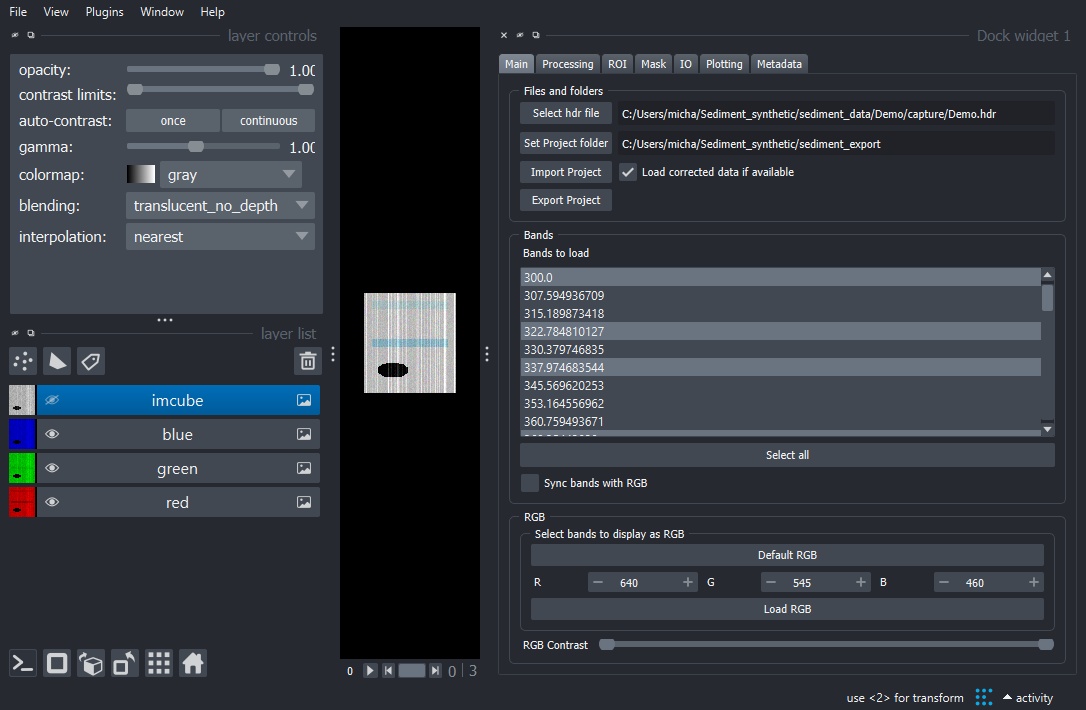

In [9]:
self.check_sync_bands_rgb.setChecked(False)
[self.qlist_channels.item(x).setSelected(False) for x in range(len(self.qlist_channels))]
[self.qlist_channels.item(x).setSelected(True) for x in [0,3,5,9]]
self._on_change_select_bands()
nbscreenshot(viewer)

### RGB

The RGB section allows you to control which bands are displayed as RGB. You can pick the wavelengths to be used for RGB using the three adjustable numbers. The closest wavelengths are selected in the list of actual wavelengths when ```Load RGB``` is pressed and the RGB layers updated. The contrast of the composite RGB image can be adjusted using the ```RGB Contrast```slider.

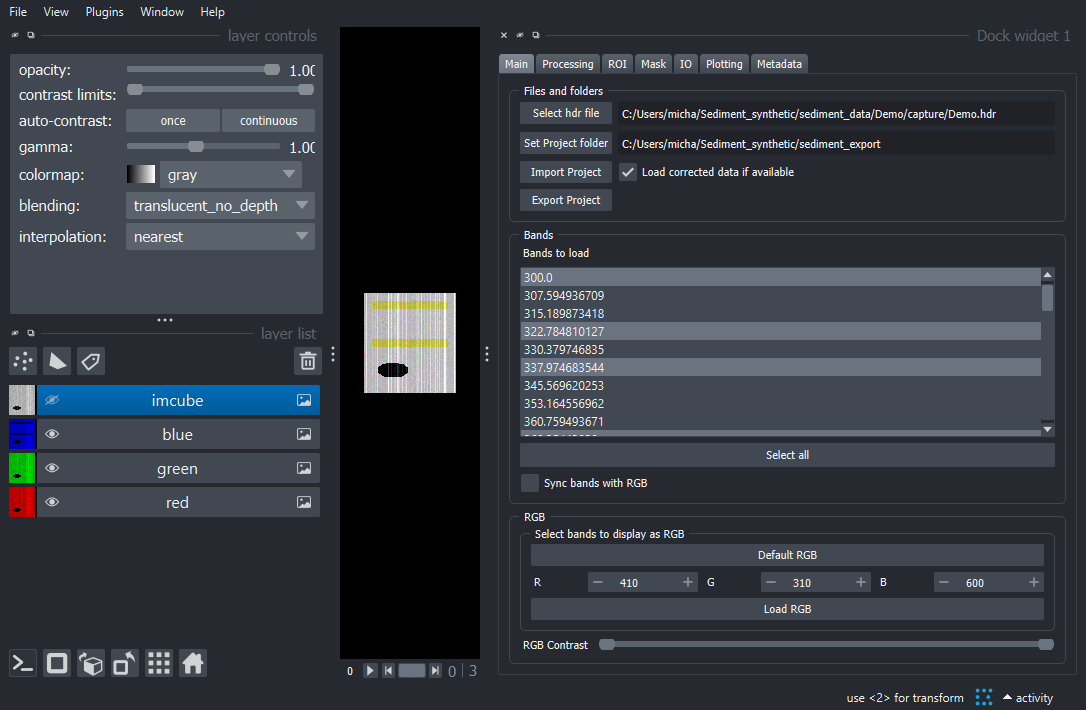

In [10]:
self.rgb_widget.spin_rchannel.setValue(410)
self.rgb_widget.spin_gchannel.setValue(310)
self.rgb_widget.spin_bchannel.setValue(600)
self.rgb_widget._on_click_RGB()
viewer.layers['imcube'].visible = False;
nbscreenshot(viewer)

## Processing

In the processing tab, one can perform background correction as well as destriping. Note that while background correction is necessary, destriping should not be used for quantitative measurements but only to display images.

### Background correction

Background correction consists in dividing the raw data by data acquired using a white standard. This allows to obtain comparable bands expressed in fraction of the white reference. In addition a dark reference (acquired without illumination) is subtracted from both the raw data and the white reference in order to remove camera artifacts. Often raw data and white reference are acquired with different settings (especially for exposure) which means both have also a separate dark reference. Correction is done with:

$i_{\textrm{corr}} = \frac{i_{\textrm{raw}}-i_{\textrm{raw-dark}}}{i_{\textrm{white}}-i_{\textrm{white-dark}}}$

where $i_{\textrm{raw}}$ is the raw data, $i_{\textrm{raw-dark}}$ is the dark reference acquired for the raw data, $i_{\textrm{white}}$ is the white reference and $i_{\textrm{white-dark}}$ the dark reference acquired for the white reference. Note that in some cases, the white reference is acquired with the same settings as the raw data, in which case $i_{\textrm{raw-dark}} == i_{\textrm{white-dark}}$.

The plugin will attempt to locate the reference files given the folder structure described above. If files are not found they can be selected manually in the interface with the ```Manual selection``` buttons. The ```Background keyword``` indicates the specific string used to name the folder containing the white reference and can be adjusted.

In ```Layer```, one can then choose what to correct: either the loaded image cube which can contains arbitrary bands, or the loaded RGB data. Note that if the option ```Sync bands with RGB``` is checked, both ```imcube``` and ```RGB``` representations are corrected.

In [11]:
self.tabs.setCurrentIndex(1)
self._on_click_background_correct()

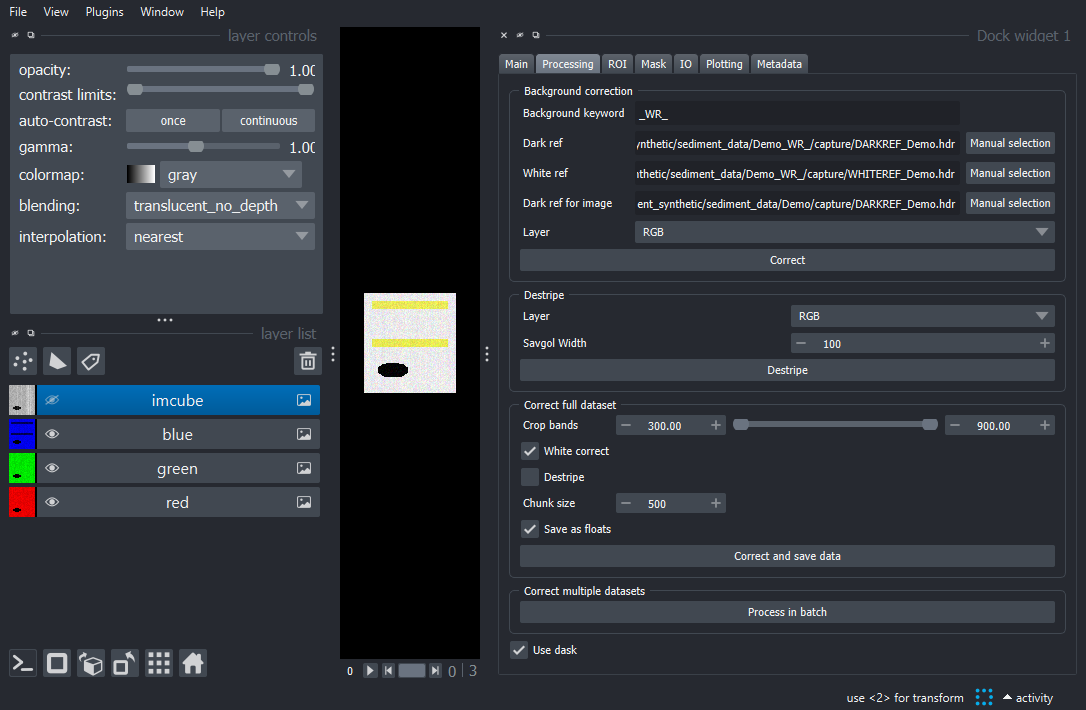

In [12]:
nbscreenshot(viewer)

### Destripe

Destriping is performed using a Savgol filter (local fit of each scan line to remove outliers). The size of the region to fit is set using the ```Savgol Width```. Note that here you can choose which layer to destripe: ```imcube```, ```imcube_corrected``` or ```RGB```. In the latter case, if you also background corrected for RGB, then the red, green, blue layers will actually contain the completely pre-processed data that one can obtain later on in batch mode. This generates another layer called ```imcube_destripe```.

In [13]:
self._on_click_destripe()

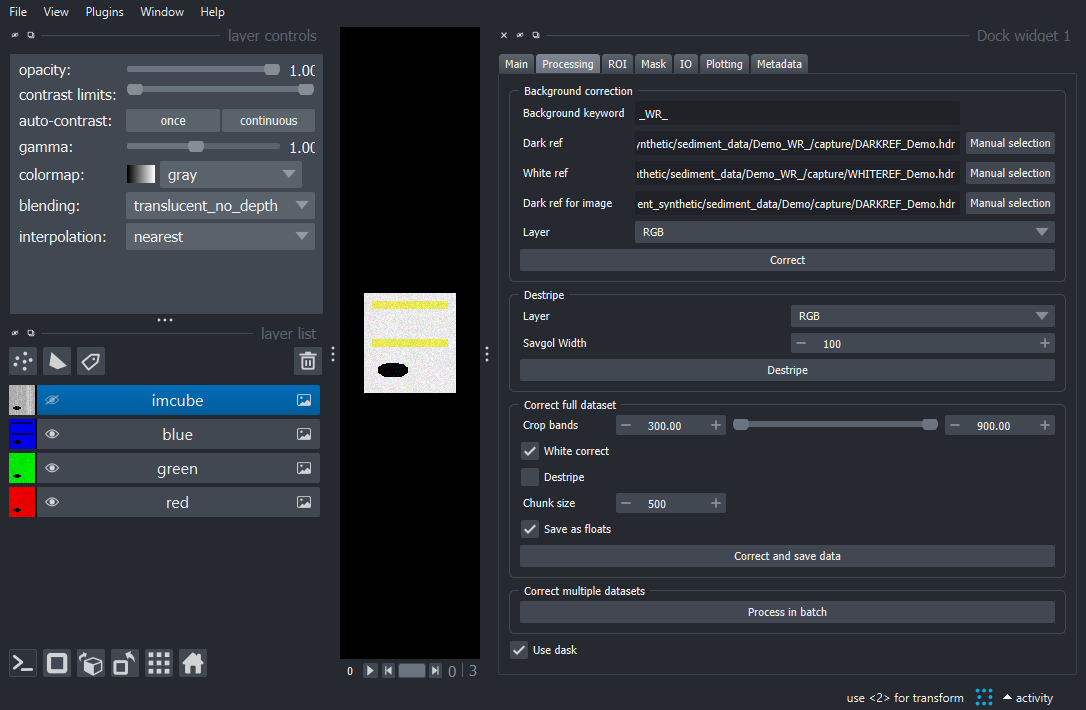

In [14]:
nbscreenshot(viewer)

### Correct full dataset

In this section you can apply corrections to the full dataset without the need to load it in the viewer (which is usually impossible because of its size). You can choose which correction to apply (destripe is always applied *after* white correction if both are selected). You can also limit to bands to process. Data are saved in zarr format with the name ```corrected.zarr```. As zarr saves data in a format split into chunks, the ```Chunk size``` option allows to control their size $N$ (in pixels). Each chunk is always composed of a single band split into $NxN$ groups of pixels. Small chunks allow for faster browsing but create many files so a balance should be found.

If no processing is needed, one should simply uncheck both the ```White correct``` and ```Destripe``` checkboxes. Normally the processed data, which after normalization should be in the range 0-1, are multiplied by $2^{12}$ and saved as integers. To avoid this and save data as floats, one can tick the box ```Save as floats``` (this can also be used to simply convert data to zarr).

In [15]:
self.check_batch_destripe.setChecked(False)
self.check_save_as_float.setChecked(False)
self._on_click_batch_correct()

After applying the correction (or just converting), the data are automatically reloaded.

### Correct multiple datasets

In this last part you can process a series of experiments using the same settings for:
- destriping
- background correction
- limits on bands

When clicking on the button, it opens a separate window where one can select a main folder to process and an export folder where to store the corrected data (below the window is shown docked to the viewer). The folder structure of the multi-experiment should be the following:

```
Multi_experiment_folder
├──Experiment1_123
│       └── capture
│           ├── myfile_123.hdr
│           ├── myfile_123.raw
│           ├── DARKREF_myfile_123.hdr
│           ├── DARKREF_myfile_123.raw
│           └── ...
│──Experiment1_WR_123
│       └── capture
│           ├── WHITEREF_123.hdr
│           ├── WHITEREF_123.raw
│           ├── DARKREF_myfile_123.hdr
│           ├── DARKREF_myfile_123.raw
│           └── ...
│──Experiment2_345
│       └── capture
│           ├── myfile_345.hdr
│           ├── myfile_345.raw
│           ├── DARKREF_myfile_345.hdr
│           ├── DARKREF_myfile_345.raw
│           └── ...
│──Experiment2_WR_345
│       └── capture
│           ├── WHITEREF_345.hdr
│           ├── WHITEREF_345.raw
│           ├── DARKREF_myfile_345.hdr
│           ├── DARKREF_myfile_345.raw
│           └── ...
├── ...
│ 
...
```
The folders ```Experiment1_123```, ```Experiment2_345``` are those that are listed in the widget. In the main export folder, each of the corrected data appears in a folder with the same name.

The same options as for the single dataset export are available here for background correction, destriping and band cropping. The options selected in the main widget are copied over automatically but can be adjusted. 

When options are set, one can click on ```Preprocess``` which will run pre-processing on all dataset within the main folder, i.e. a ```corrected.zarr``` file is generated for each dataset.

Note that this widget can be opened as a regular widget without the main widget, as shown here.

In [16]:
from napari_sediment.widgets.batch_preproc_widget import BatchPreprocWidget
viewer2 = napari.Viewer()
self2 = BatchPreprocWidget(viewer2)
viewer2.window.add_dock_widget(self2);

In [17]:
self2._on_click_select_main_folder(main_folder=synth_path.joinpath('sediment_data/'))
self2.file_list.setCurrentRow(0)
self2.qlist_channels.setCurrentRow(30)
self2.qlist_channels._on_change_channel_selection()

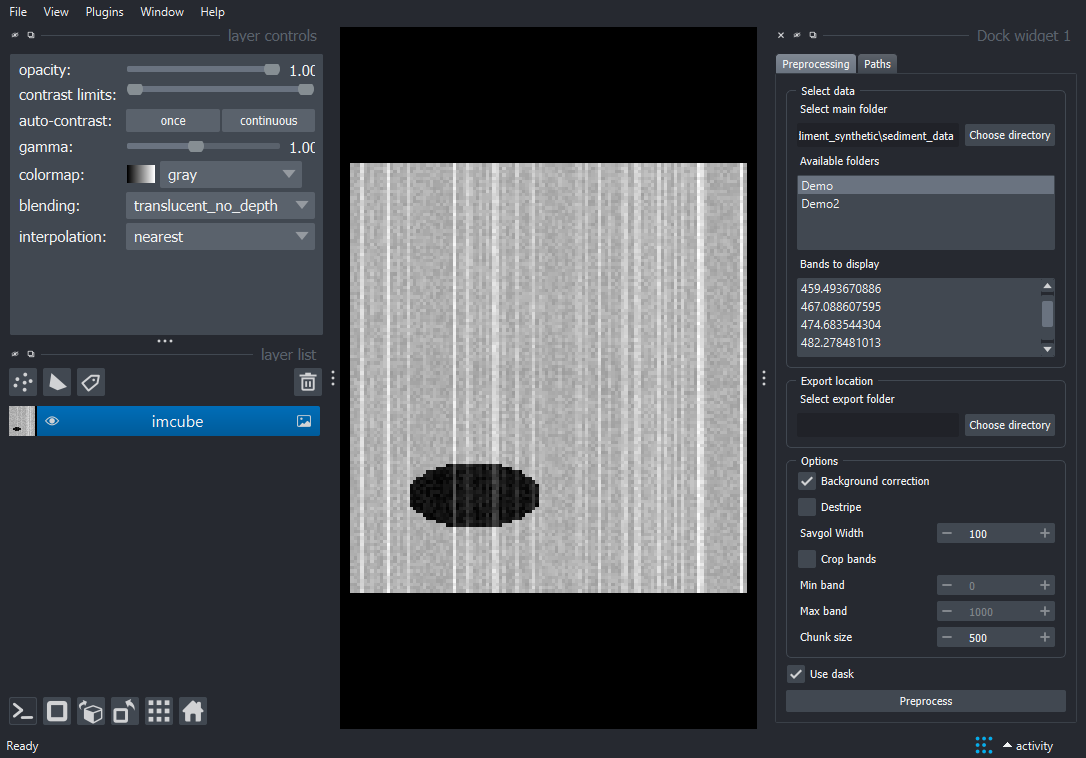

In [18]:
nbscreenshot(viewer2)

In [19]:
self2.preproc_export_path_display.value = synth_path.joinpath('sediment_export_series')

In [20]:
self2.check_do_background_correction.setChecked(True)
self2.check_use_dask.setChecked(False)
self2._on_click_batch_correct()


Preprocessing bands: 100%|██████████| 80/80 [00:00<00:00, 197.20it/s]

Preprocessing bands: 100%|██████████| 80/80 [00:00<00:00, 295.17it/s]


## ROI

### Main ROI

In the next step we select the region to be kept for analysis. Often raw data contain borders with very different signals from the actual relevant regions that might disturb further analysis steps and need to be discarded. One can add a main ROI encompassing the full picture using ```Add main ROI```. The horizontal size of this ROI can also be set with ```Main ROI width```. The ROI can then be manually adjusted directly in the layer using the editing tools.

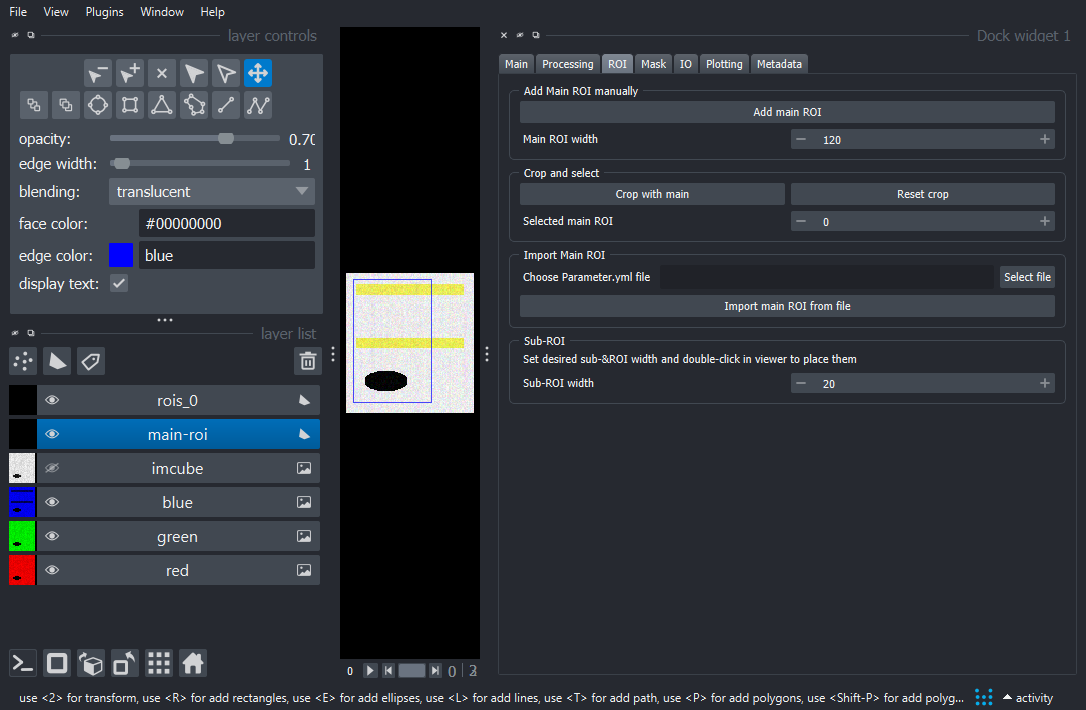

In [21]:
self.tabs.setCurrentIndex(2)
self._on_click_add_main_roi()
self.viewer.layers['main-roi'].data = [np.array([[5,7],[120,7],[120,80],[5,80]])]
nbscreenshot(viewer)

Note that you might be interested in multiple separate main rois in your experiment. So you can just add as many as you want:

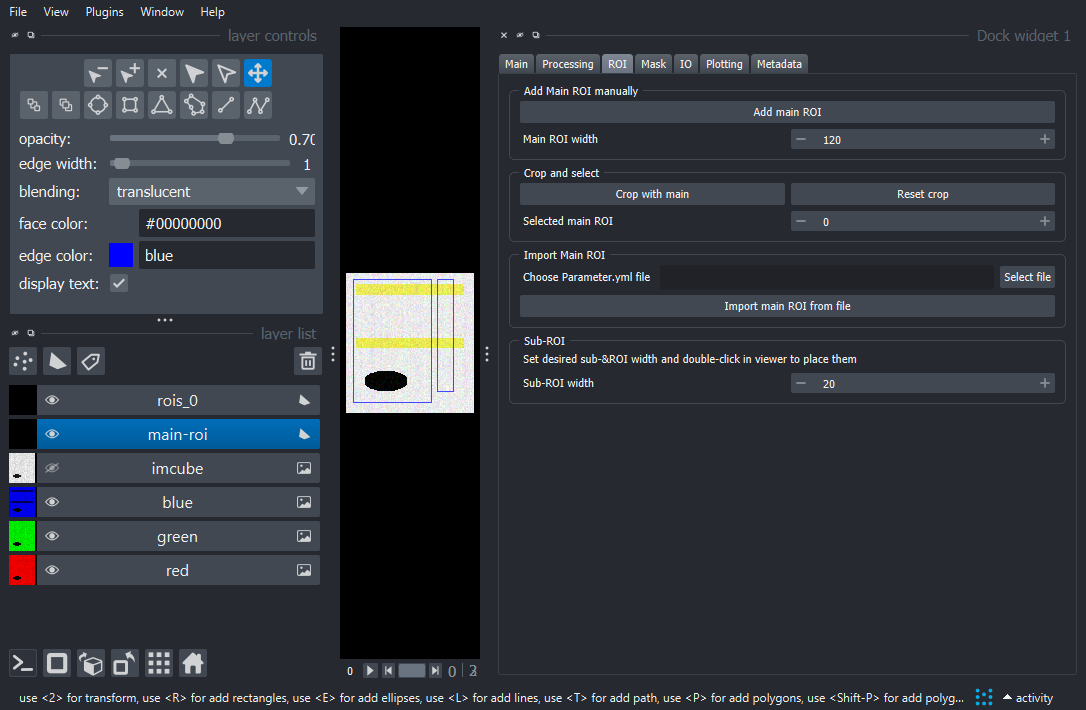

In [22]:
self._on_click_add_main_roi()
self.viewer.layers['main-roi'].data = [np.array([[5,7],[120,7],[120,80],[5,80]]),
                                       np.array([[5,85],[110,85],[110,100],[5,100]])]
nbscreenshot(viewer)

### Sub-ROI

For further steps, we need to select small regions with the main rois called sub-ROIs. To have sub-ROIs that are correctly sized, we first need to crop the image using the main ROI using ```Crop with main```. We can switch between main ROIs using ```Selected main ROI```. Once the image has been cropped, we can add sub-ROIs to it by double-clicking in the image. The width of the sub-ROIs is controlled with ```Sub-ROI width```.

Let's crop using the first main ROI:

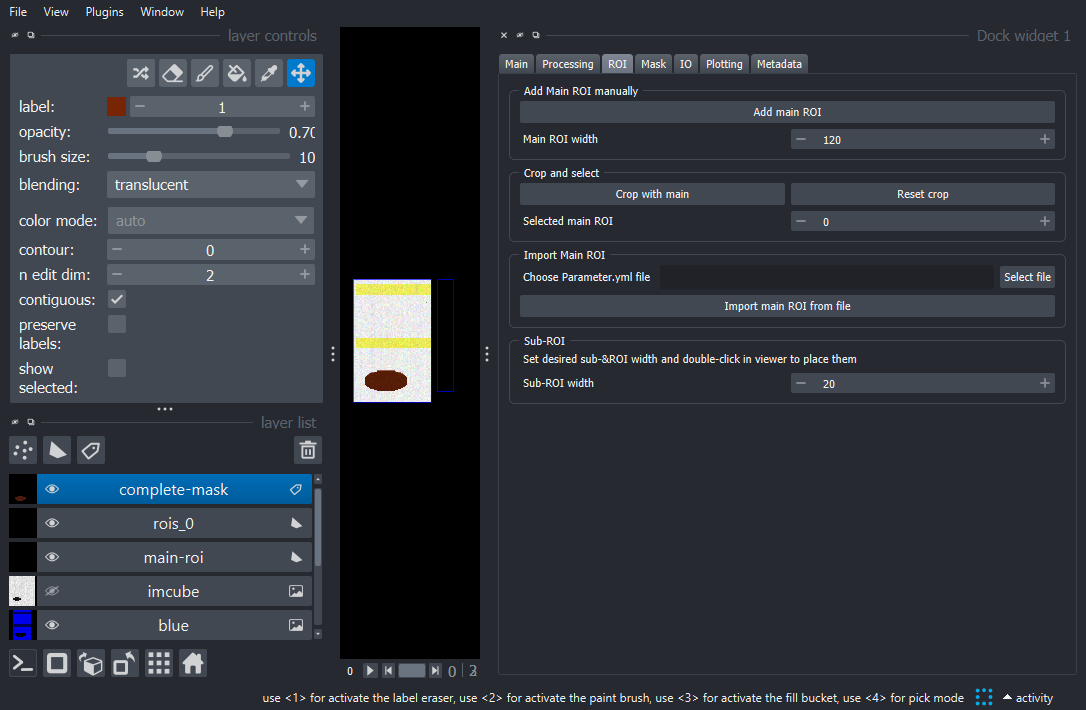

In [23]:
self._on_crop_with_main()
nbscreenshot(viewer)

And now we can add an analysis ROI:

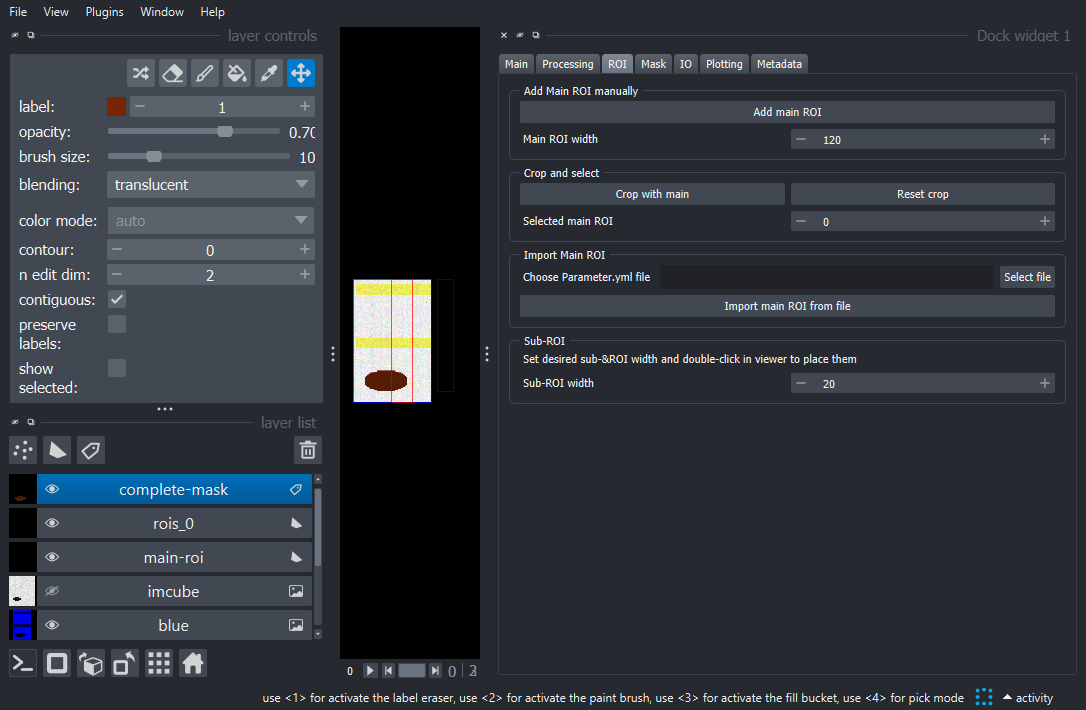

In [24]:
self._add_analysis_roi(cursor_pos=[0,0,52,0])
nbscreenshot(viewer)

In order to import the same main ROI across different datasets, we can import an existing one from a ```Parameters.yml``` file saved in an other export folder.

## Mask

Finally, we may want to remove or mask unwanted regions. Those are annotated as having label 1 in a labels layer. Masks can be created in multiple ways briefly mentioned below. We only give more details on the more complex pixel classifier solution.

###  Create one ore more masks
A series of (Semi-)Automated methods are also available for this task.

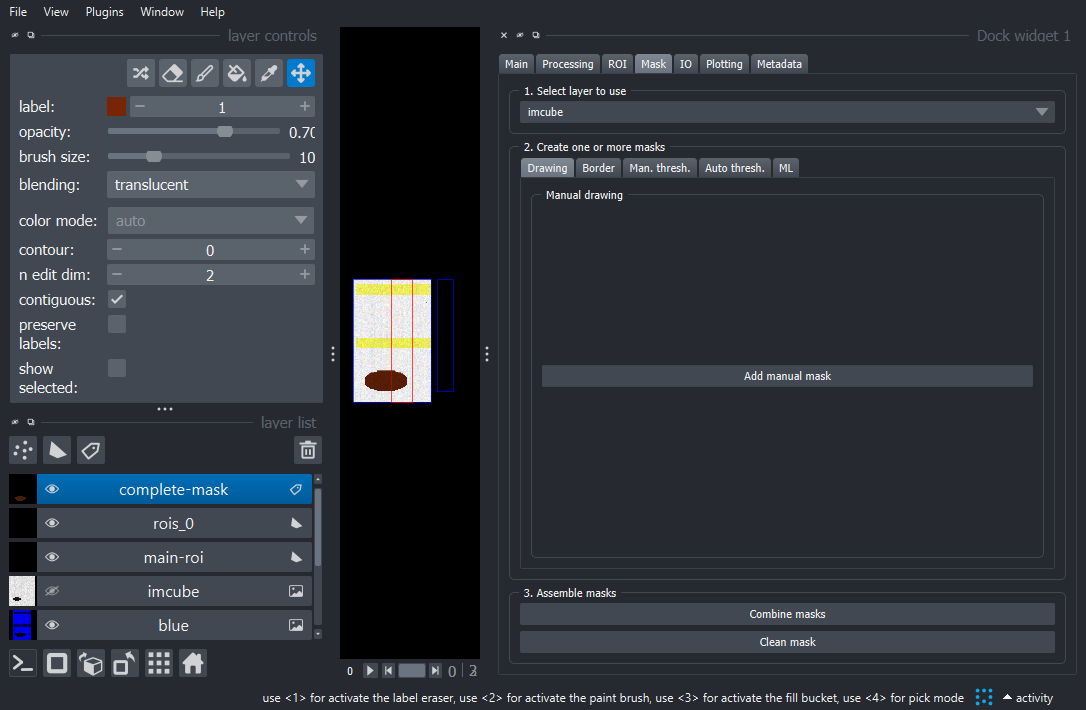

In [25]:
self.tabs.setCurrentIndex(3)
nbscreenshot(viewer)

- Drawing: allows to add a mask layer and to annotate it manually
- Border mask will attempt to detect rough borders around the image and try to mask them. This generates a layer called ```masked_border```. As normally such borders are removed with the main ROI, this approach will be deprecated.
- Man. threshold: using the slider a minimum and maximum threshold can be applied on the average intensity of the RGB data.
- Automated threshold: here the values of the min and max threshold are computed automatically by fitting the average RGB intensity distribution with a Gaussian, and removing pixels beyond a certain width that can be adjusted
- Pixel classifier: here a classifier is trained based on a few annotated streaks on the image.

Each type of masking will generate a layer with a different name. Those layers can be combined in the end.

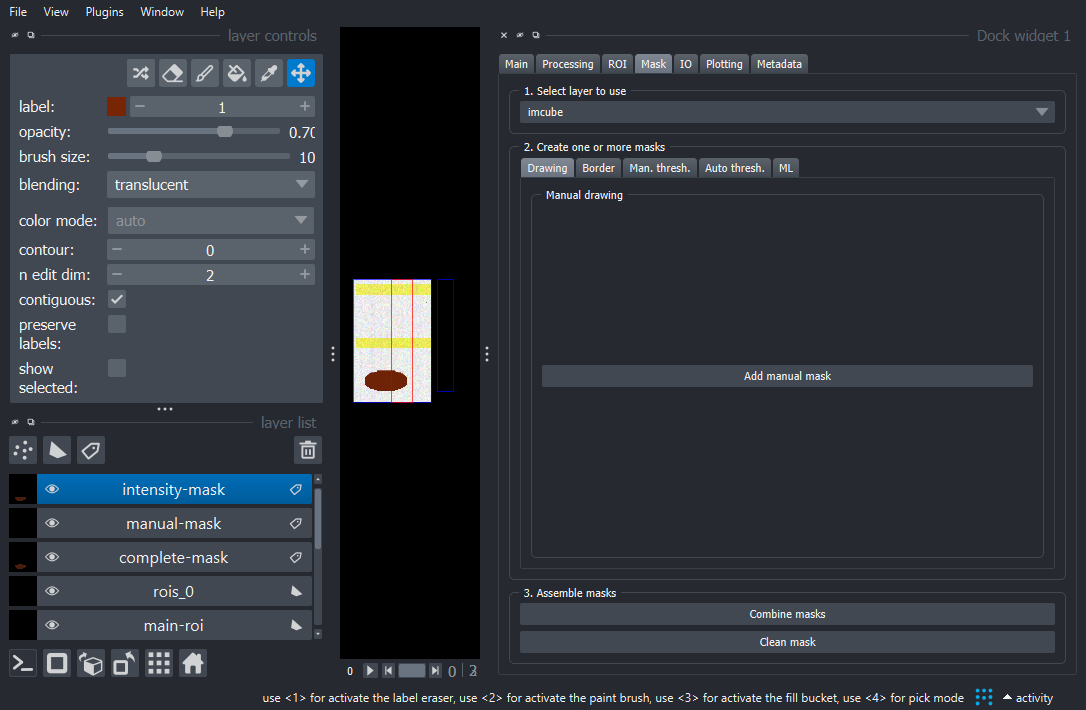

In [26]:
self._add_manual_mask()
self.slider_mask_threshold.setValue((1000, 2157))
self._on_click_intensity_threshold()
nbscreenshot(viewer)

### Pixel classifier

Very often, small distinctive features have to be masked on the image, such as cracks and defects. Since those regions have a different "spectral" signature, one can annotate a few examples of those and train a Machine Learning algorithm to recognize them. This is what the separate [https://github.com/guiwitz/napari-convpaint](napari-convpaint) plugin allows to do. For ease of use, it has been integrated directly in the plugin.

To be able to do the annotation, one needs first to choose which layer to use: in ```Layer to segment``` both single channels (such as ```red```) or multi-channel layers such as ```imcube``` can be selected for training. More channels means longer computations but also more precision as relevant features will be detected in all channels. Then one can proceed with adding sparse annotations. In case annotations are available from another source they can be imported as a labels layer and selected in ```Layer for annotation```. Otherwise, one clicks on ```Add annotations/segmentations layers``` which will add an ```annotations```layer. **Examples of both foreground (regions to mask) and background ("good" regions) have to be provided.** Foreground should be annotated with label 1 background with label 2. Favor many smaller streaks rather than a large streak across the image. Also start with few streaks and add more as needed: more annotations means slower computation. If you work with large images we **strongly recommend** to ```Donwsample``` (```Options``` section) the image by a factor of ~4 to speed up computations. Once happy with annotations, you can create an accurate mask with full resolution.

Here we add two small annotations:

In [27]:
self.mask_tabs.setCurrentIndex(4)

In [28]:
self.mlwidget.select_layer_widget.value = self.viewer.layers['imcube']
self.mlwidget.radio_multi_channel.setChecked(True)

In [29]:
self.mlwidget.add_annotation_layer()

In [30]:
self.viewer.layers['intensity-mask'].visible = False

In [31]:
self.viewer.layers['annotations'].data[45:50, 25:35] = 2
self.viewer.layers['annotations'].data[100:105, 23:29] = 1
self.viewer.layers['annotations'].refresh()

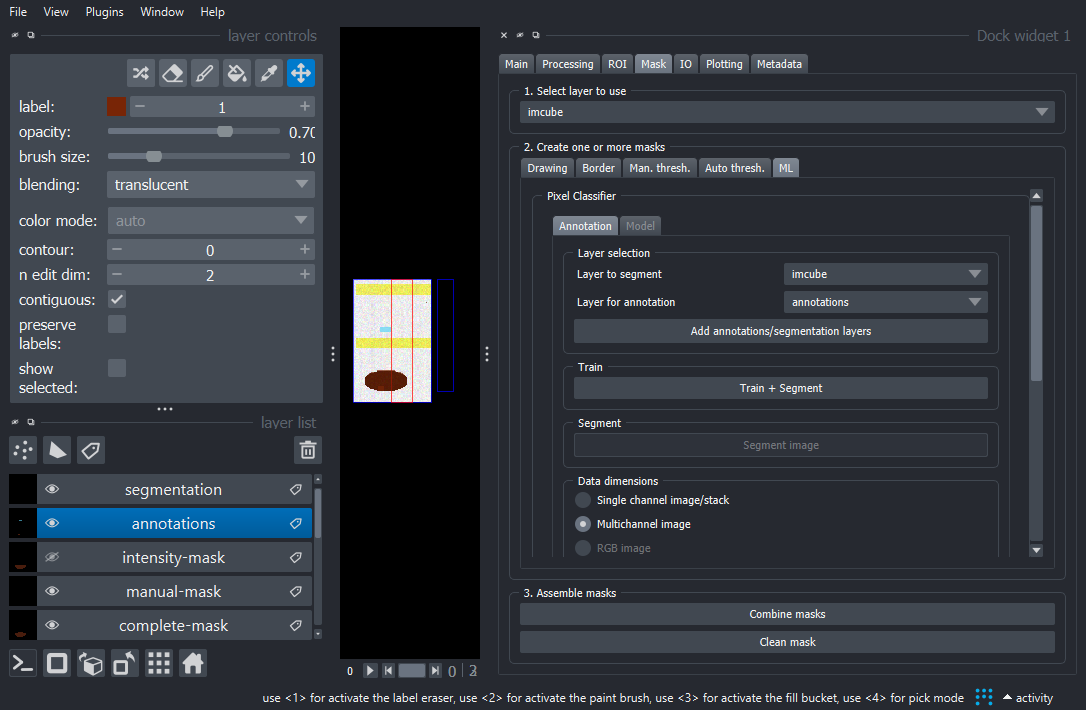

In [32]:
nbscreenshot(viewer)

Then one can train the model using ```Train + Segment``` and create a mask with ```Segment Image```. If the result is not satisfactory, one can add more annotations, retrain and re-generate the mask. The trained model can be saved using ```Save trained model``` and reloaded later. In the latter case, one can directly use ```Segment image``` without training. You will find more information directly in the napari-convpaint documentation.

In the end you will obtain a new layer ```ml-mask``` with the mask, as well as a ```segmentation``` layer with the segmentation of the two annotated labels.

In [33]:
self.mlwidget.spin_downsample.setValue(1)
self.mlwidget.update_model_btn.clicked.emit()

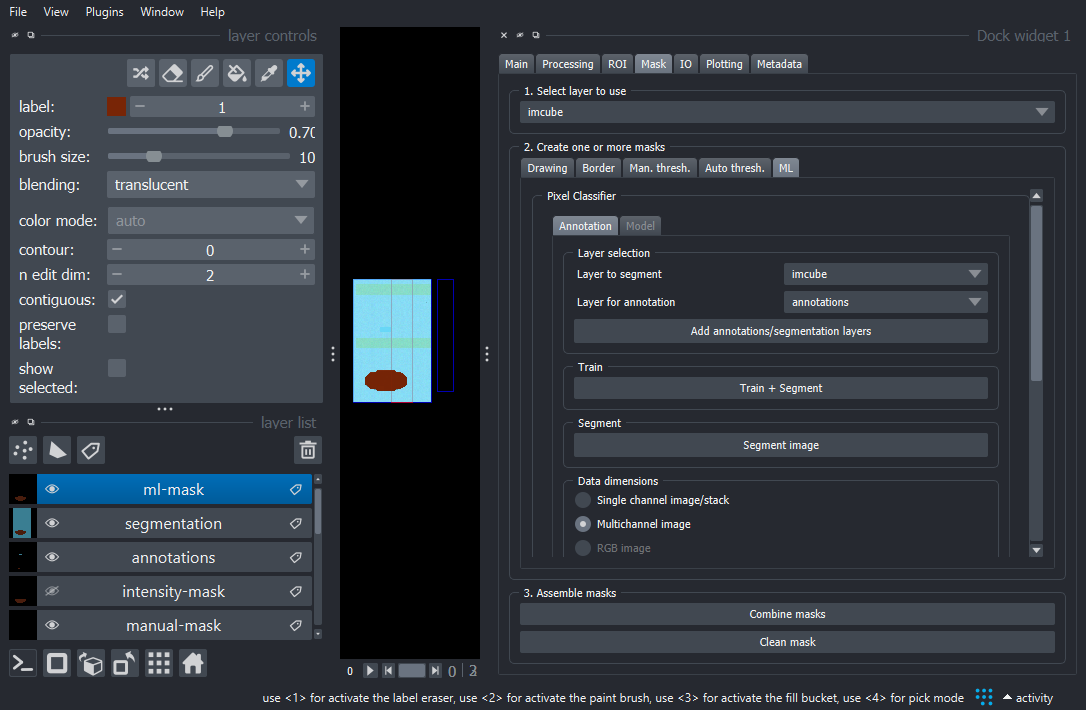

In [34]:
nbscreenshot(viewer)

### Assemble

As potentially multiple masks were generated, e.g.  one with a threshold, one via ML etc. those need to be combined in a single mask. This can be done using ```Combine masks```. Finally the mask can be cleaned by closing holes in the mask using ```Clean mask```. The full mask will be available in ```complete-mask```. Note that when later saving the project, only the latter is saved and not all independent masks.

In [35]:
viewer.layers['segmentation'].visible = False
viewer.layers['annotations'].visible = False
self._on_click_combine_masks()

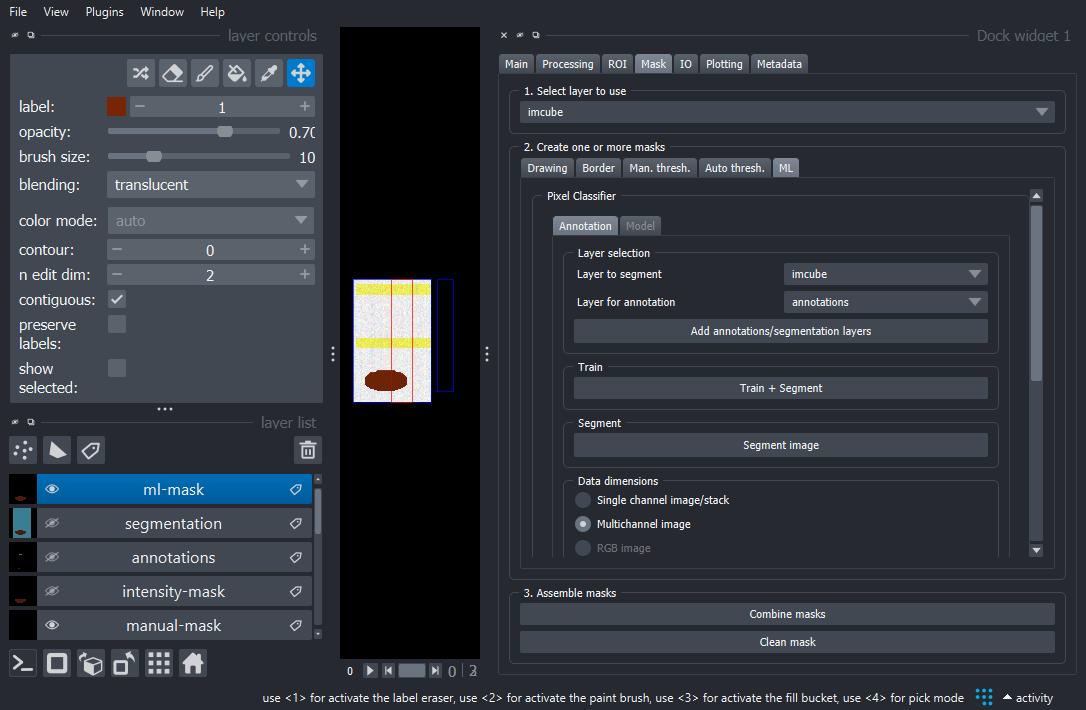

In [36]:
nbscreenshot(viewer)

## IO

Finally when all the work is done, one needs to save all the information, including e.g. metadata, masks, ROIs etc. This can be done in the ```Main``` tab using the ```Export Project``` button. If an export folder has been set in the Main tab, that location will be used, otherwise a new one should be selected. That saved project can later on be re-imported as well.

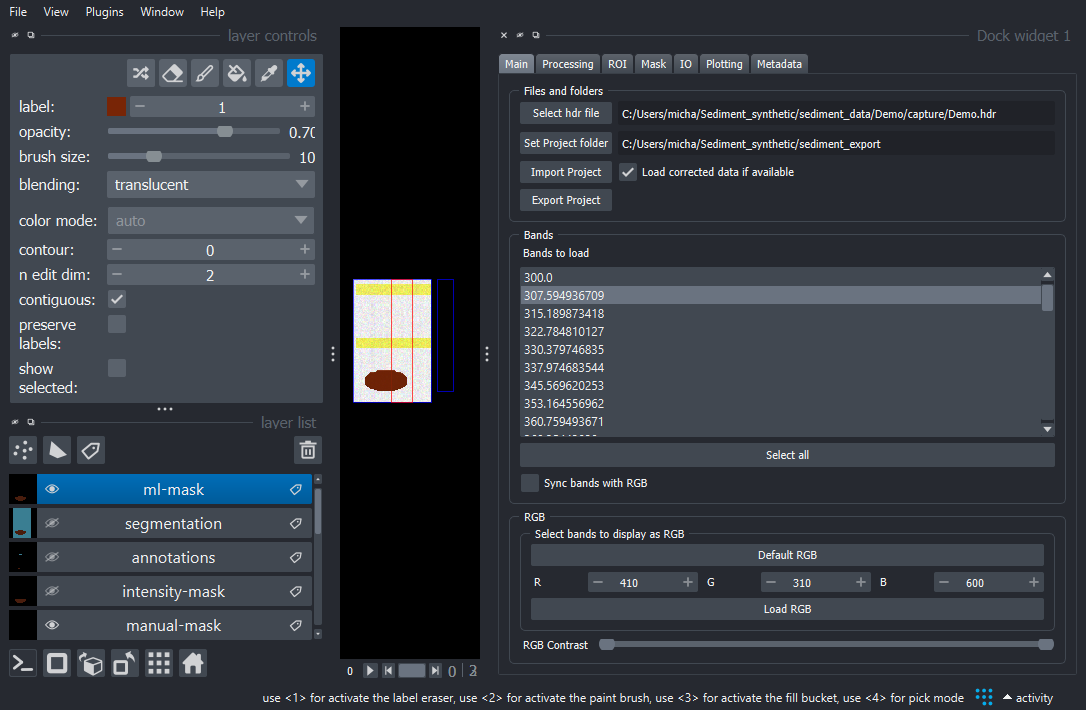

In [37]:
self.tabs.setCurrentIndex(0)
nbscreenshot(viewer)

In [38]:
self.export_project()

The exported files will be:
- ```corrected.zarr```: the corrected data previously exported
- ```Parameters.yml```: a file with information regarding the location of data and background data, location of ROIs etc.
- ```roi_0```, ```roi_1``` etc.: series of subfolders for each main ROI, for the moment only containing the mask.

Finally in the ```IO``` tab one can export a snapshot of the current view (for presentation purposes) as well as import/export masks potentially generated with another tool.

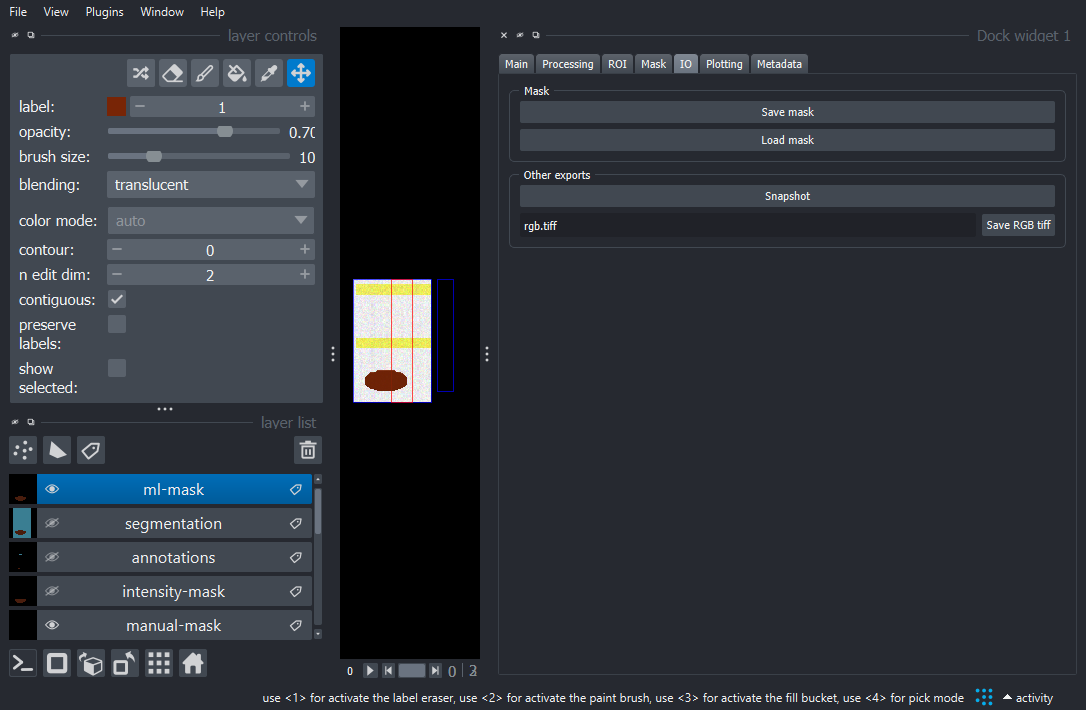

In [39]:
self.tabs.setCurrentIndex(4)
nbscreenshot(viewer)

## Plotting

In the Plotting tab, one can visualize the spectrum for a single pixel. This is achieved by hovering over the image and holding the Shift key. Only the data from the loaded channels is displayed. This means that for large data, one can only display all channels after conversion to the zarr format (otherwise the full dataset is too large to load).

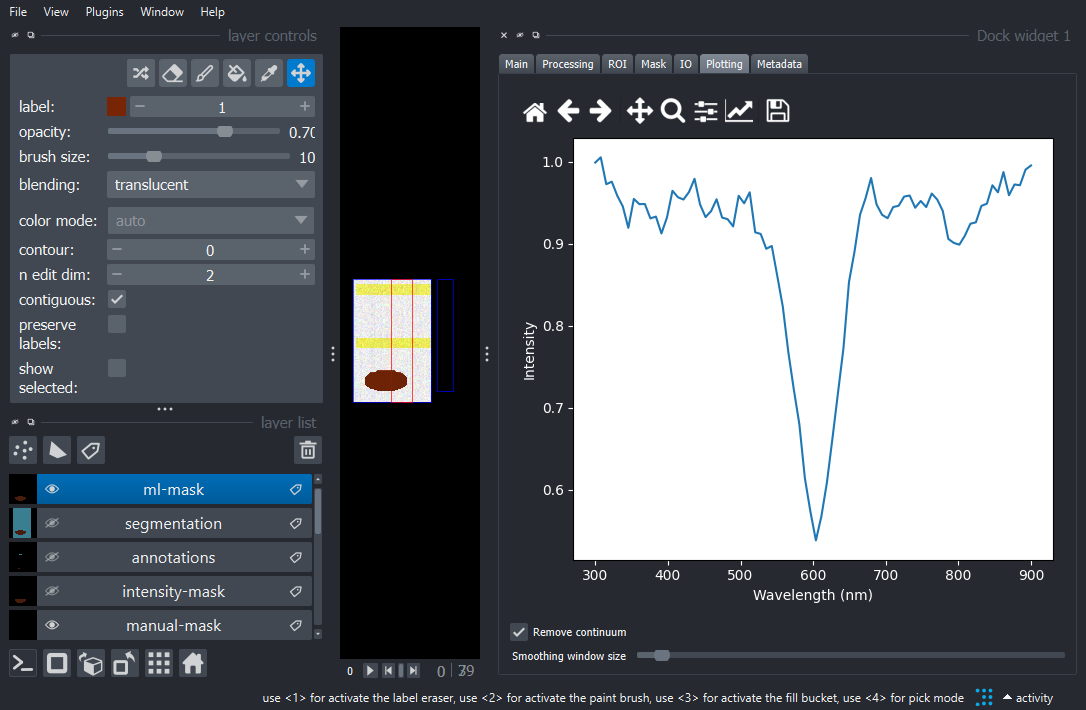

In [40]:
self.tabs.setCurrentIndex(5)

self.check_sync_bands_rgb.setChecked(False)
[self.qlist_channels.item(x).setSelected(True) for x in range(len(self.qlist_channels))]
self._on_change_select_bands()

self.spectral_pixel = self.viewer.layers['imcube'].data[:, 64, 34]
self.update_spectral_plot()

nbscreenshot(viewer)

## Metadata

When an .hdr file is loaded, it's metadata such as wavelength of each band, are also read. Additional info such as location of data acquisition and pixel size etc. can be set here.

For the pixel size, you can either enter a number manually in ```Pixel Size``` as well as set the corresponding unit (in this example the pixel size is 2.5mm):

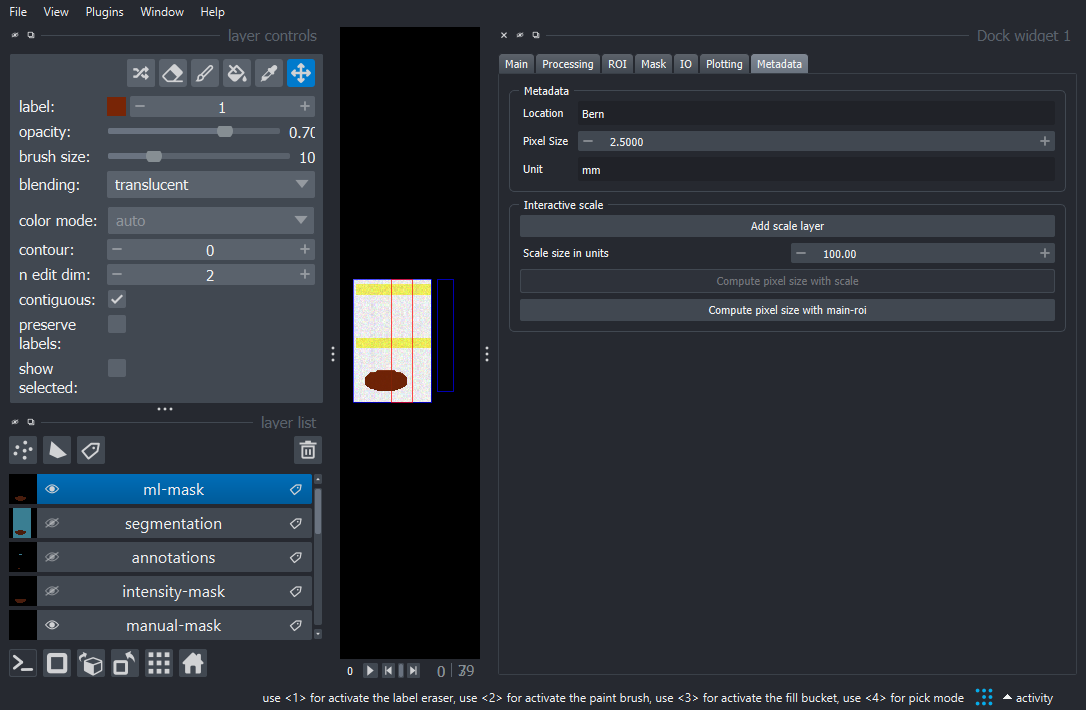

In [41]:
self.tabs.setCurrentIndex(6)
self.metadata_location.setText('Bern')
self.spinbox_metadata_scale.setValue(2.5)
nbscreenshot(viewer)

There are two alternatives to set the scale:
1. If one knows the size of the selected main-roi, one can just enter it in the ```Scale size in units``` and the click on ```Compute pixel size with main-roi```.
2. One can add an adjustable scale bar (green) to the image using ```Add scale layer```, adjust its size and then specify it's size in actual units. This is useful e.g. if a ruler is visible in the image. One can then compute the scale by clicking on ```Compute pixel size with scale```.

In [42]:
self._on_click_add_scale_layer()

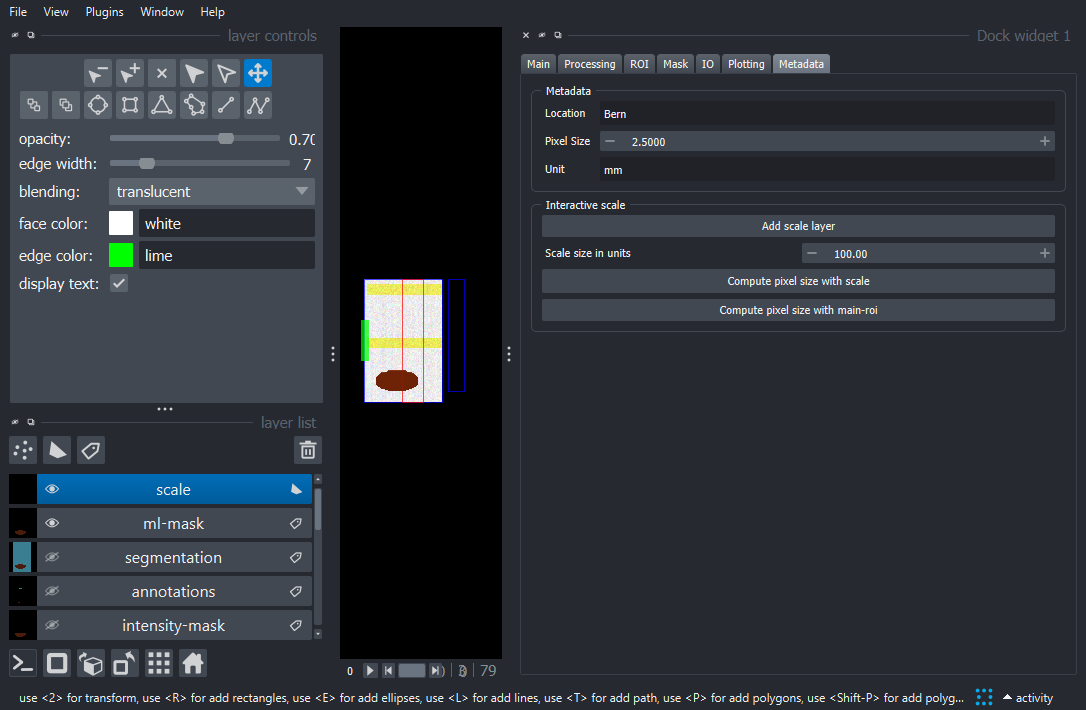

In [43]:
nbscreenshot(viewer)

## Re-loading project

Once the plugin is closed, one can re-import the project by simply specifying the Export folder. As data location is saved in the ```Parameters.yml``` file, no need to specify it here (note that re-loading will stop working if you move the data!)

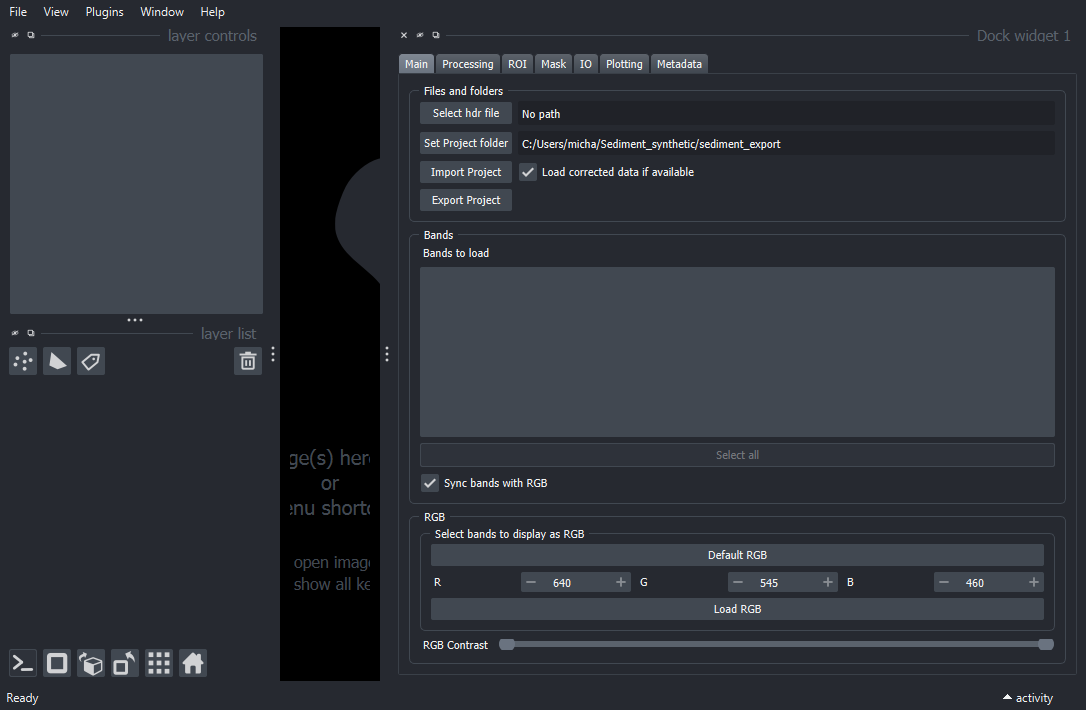

In [44]:
viewer = napari.Viewer()
self = SedimentWidget(viewer)
viewer.window.add_dock_widget(self);

self.export_folder = synth_path.joinpath('sediment_export')
self.export_path_display.setText(self.export_folder.as_posix())
nbscreenshot(viewer)

Upon clicking on ```Import Project```, this is the re-loaded state you will see:

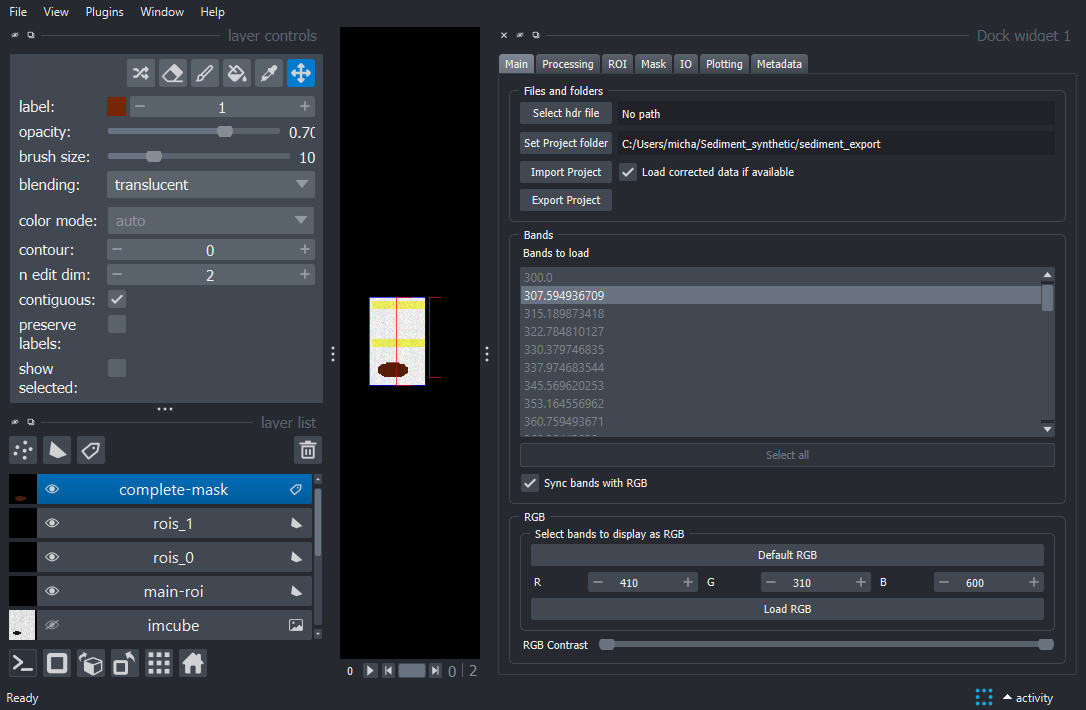

In [45]:
self.import_project()
nbscreenshot(viewer)